<h1>MINI PROJET : Classification des chiffres ecrit a la main</h1>

<table style="border : 1px solid black; text-align : center">
    <tr style="border : 1px solid black">
        <td style="border : 1px solid black">
            <h3>Travail est realise par :</h3>
            <ul style="text-align : left;">
                <li>ABOUZI Anass</li>
                <li>CHAHBOUNE Achraf</li>
                <li>AMZIL Ammar</li>
                <li>CHAFIK Anas</li>
            </ul>
        </td>
        <td style="border : 1px solid black"><h3>Precision moyenne atteinte : 71.95%</h3></td>
        <td style="border : 1px solid black"><h3>Temps d'execution moyen du note book : 43.25 s</h3></td>
    </tr>
    
    
</table>

<h2>Description du projet :</h2>

<h3>La classification dans le domaine d'informatique est l'ensemble des techniques qui permet a une machine de categorizer des images a partir de leurs contenus, cela necessite des representations precise et robuste du contenu des images. Aujourd'hui, plusieurs technique de classification existe sois par l'utilisation des reseaux neurons ou les techniques de "clustering" ...ect, dans ce projet on se mene a la classification des images des chiffres ecrits a la main en utilisant des descripteurs d'orientation de region et la methode "KNN", notre objectif est d'entrainer un model descriptive precis a 60% ou plus.</h3> 

<h2>Importation des librairies.</h2

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import utility_functions
import cv2 as cv
from skimage import ( transform, feature)

<h2>Recuperation de la base de donnes.</h2>

<h3>On va utiliser une sous-ensemble de l'ensemble celebre "Mnist" qui va contenir 800 images d'entrainement et 200 images de teste (la distribution des classes doit etre equiprobable), chaque image est de taille 28x28 et contient un chiffre ecrit a la main avec une label indiquant le chiffre correspondant.</h3>

In [2]:
#chargement des ensembles originales
full_training_set = np.genfromtxt("Mnist_data_set/mnist_train.csv", dtype=np.uint16, delimiter=",", skip_header=1)
full_test_set = np.genfromtxt("Mnist_data_set/mnist_test.csv", dtype=np.uint16, delimiter=",", skip_header=1)
print(full_training_set.shape)
print(full_test_set.shape)

(60000, 785)
(10000, 785)


<h2>Extraction de 80 echatillions de chaque classe pour l'ensemble d'entrainement et 20 echantillions de chaque classe pour l'ensemble de teste pour avoir des ensembles equilibre.</h2>

In [3]:
def get_sub_set(full_set, N) :
    sub_set = []
    
    for i in range(10) :
        size = 0
        k = 0
        #pour chaque chiffre i on va empiler N echantillon de i au sous-ensemble
        while size < N :
            if full_set[k, 0] == i :
                sub_set.append(full_set[k])
                size += 1
            k += 1
    return np.array(sub_set)

<h2>Creation des bases donnes utilise pour l'entrainement et le test de notre model.<h2>

In [4]:
training_set = get_sub_set(full_training_set, 80)
test_set = get_sub_set(full_test_set, 20)

In [5]:
print(training_set.shape)
print(test_set.shape)

(800, 785)
(200, 785)


<h2>Exemples des elements sur les quels on va agir.</h2>

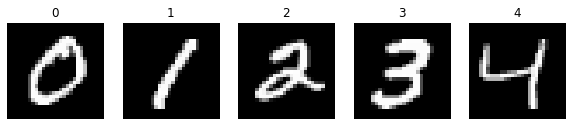

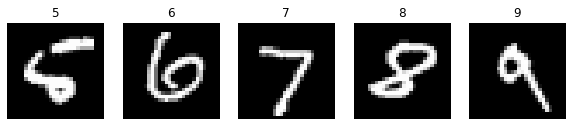

In [6]:
plt.figure(figsize=[10.0, 10.0])
for i in range(5) :
    plt.subplot(1,5,i + 1)
    plt.imshow(training_set[i * 80, 1:].reshape((28, 28)), cmap="gray")
    plt.title(training_set[i * 80, 0])
    plt.axis("off")
plt.show()
plt.figure(figsize=[10.0, 10.0])
for j in range(5) :
    plt.subplot(1,5,j + 1)
    plt.imshow(test_set[100 + j * 20, 1:].reshape((28, 28)), cmap="gray")
    plt.title(test_set[100 + j * 20, 0])
    plt.axis("off")
plt.show()

<h2>Analyse des elements de la base de donnees.</h2>

<h3>Notre base de donnes contient des images en niveau de gris de chiffres ecrit a la main, on peut tout de suite eliminer les descripteurs de couleurs et de textures puisqu'il n'apporte aucune information sur le chiffre, donc pour pouvoir decrire le contenu de chaque image on doit utiliser un descripteur de forme, regions ou un melange entre les deux. Le descripteur qu'on va utiliser est <em><b>L'HISTOGRAMME DES GRADIENTS ORIENTE</b></em> aussi appele HOG. Le HOG  est une technique de détection d'objets populaire dans le domaine de la vision par ordinateur. Il a été introduit pour la première fois par Dalal et Triggs en 2005. Cette technique consiste à extraire des caractéristiques d'une image en se concentrant sur la distribution de l'orientation des gradients de couleur dans l'image, mais avant d'implimanter ce descripteur, on doit tout d'abord pretraiter nos donnees pour repondre a deux contraintes :</h3>
<ol>
    <li><h3>La taille des images n'est pas optimale pour l'utilisation de cette methode, la taille recommande dans la literature est 64x128, mais dans notre cas on se restreit a 32x64.</h3></li>
    <li><h3>L'inclinaison de l'ecriture de differentes personnes, chaque personne va ecrire le chiffre '1' avec une inclinaison differente ce qui va rendre beaucoup plus difficile la comparaison par orientation, donc on doit detecter et correcter l'inclinaision de chaque image avant de le decrire.</h3></li>
</ol>

<h2>Detection et correction d'inclinaison :</h2>
<h3>L'idee c'est l'utilisation des moments centrale de l'image pour detecter l'inclinaison et les utiliser pour creer une transformation inverse de l'inclinaison detecter.</h3>
<h3>Le moment centrale calculer par la formule : <h3>
<img src="markup_images\moment_central.png" />

<h2>voici le code pour correction</h2>

In [7]:
def deskew(img):
    taille = img.shape[0]
    #fonction predefinie de opencv qui retourne un dictionaire contenant les moments spacials, centrales et centrales normalize
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
    # pas d'inclinaison
        return img.copy()
    # Calcule de l'inclinaison en fonction des momemts centrales.
    skew = m['mu11']/m['mu02']
    # Calcule de la transformation affine pour la correction de l'inclinaison.
    M = np.float32([[1, skew, -0.5*taille*skew], [0, 1, 0]])
    # Application de la transformation affine
    img = cv.warpAffine(img, M, (taille, taille), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return img

<h2>Visualization de la correction d'inclinaison</h2>

In [8]:
img = np.array(training_set[84][1:].reshape((28, 28)), dtype=np.float32)

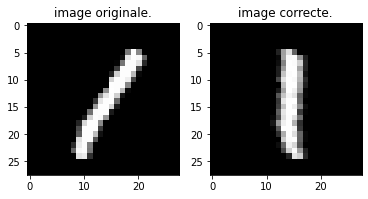

In [9]:
corrected_img = deskew(img)
plt.subplot(1, 2, 1)
plt.title("image originale.")
plt.imshow(img, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("image correcte.")
plt.imshow(corrected_img, cmap="gray")

<h2>Redimensionement des images.</h2>

In [10]:
resized_img = transform.resize(corrected_img, (64, 32))

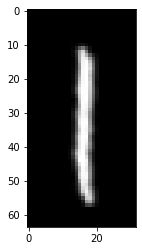

In [11]:
plt.imshow(resized_img, cmap="gray")

<h2>Histogramme des gradients oriente.</h2>

<h3>Le HOG se base sur le fait que les bords d'un objet dans une image ont souvent une orientation prédominante. En utilisant l'orientation des gradients de l'image, le HOG peut détecter la forme d'un objet. Pour faire cela, l'algorithme effectue les étapes suivantes :</h3>
<ol>
    <li><h3>Calcul des gradients : Pour chaque pixel de l'image en niveaux de gris, nous calculons le gradient sur l'axe horizontale (X) et verticale (Y) en utilisant les filtres de sobels : <img src="markup_images\filtres_sobel.png"/> puis on calcule la magnitude et l'orientation des gradients en utilisant les formules suivantes : <img src="markup_images\magnitude_orientation.png"/></h3></li>
    <li><h3>Division de l'image en cellules : L'image est divisée en petites cellules, généralement de taille 8x8 ou 16x16.</h3></li>
    <li><h3>Calcul des histogrammes d'orientation pour chaque cellule : Pour chaque cellule, nous créons un histogramme d'orientation des gradients. Nous discrétisons généralement l'orientation en 9 orientations (de 0 a 160 avec un pas de 20), et pour chaque pixel de la cellule on distribue la magnitude du gradient sur les deux orientations voisine a l'orientation de la pixel selon la proximité de l'orientation a chacun des voisins. <img src="markup_images\magnitude_distribution.png"/></h3></li>
    <li><h3>Division des cellules en blocs : Les cellules sont regroupées en blocs plus grands, généralement de taille 2x2 à 4x4, </h3></li>
    <li><h3>Calcul des histogrammes de blocs : Pour chaque bloc, nous additionnons les histogrammes d'orientation des cellules qui le composent pour obtenir un histogramme de bloc unique et on le normalise (dans notre programme on utilise la normalisation L1-sqrt).</h3></li>
</ol>
<h3>En fin de compte, nous obtenons une image representant l'orientation de l'image.</h3>

(756,)


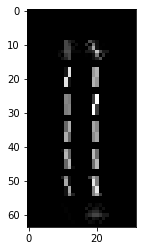

In [12]:
fd, hog_img = feature.hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L1-sqrt')
print(fd.shape)
plt.imshow(hog_img, cmap="gray")

<h2>Extraction des descripteurs</h2>

In [13]:
def get_descripteur(img_set) :
    l = img_set.shape[0]
    mat_desc = np.zeros((l, 756))
    for i in range(l) :
        corrected_img = deskew(img_set[i][1:].reshape((28, 28)))
        resized_img = transform.resize(corrected_img, (64, 32))
        fd = feature.hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L1-sqrt')
        mat_desc[i] = fd
    return mat_desc


<h2>Descripteurs d'entrainement et de teste.</h2>

In [14]:
training_desc = get_descripteur(training_set)
test_desc = get_descripteur(test_set)

In [15]:
print(training_desc.shape)
print(test_desc.shape)

(800, 756)
(200, 756)


<h2>Evaluation : (les fonctions sont predefinie dans le tp)</h2>

<h3>Matrice de distance.</h3>

In [16]:
distance_mat = utility_functions.get_distance_mat(training_desc, test_desc)

In [17]:
print(distance_mat.shape)

(800, 200)


In [18]:
print(distance_mat)

[[1.74004569 2.02508812 2.22881343 ... 4.08258421 3.62703196 3.86764997]
 [2.30053742 2.77487602 2.55277151 ... 4.06233787 3.51322103 3.83238334]
 [2.93310756 2.83432153 2.52241101 ... 3.92452505 3.76851334 3.76563753]
 ...
 [4.13370533 4.25034021 3.77066971 ... 1.93795027 3.30262173 3.0040477 ]
 [4.38229683 4.44348276 3.97833951 ... 2.05751583 3.39125223 2.80828493]
 [4.98826988 4.96495879 4.68009839 ... 3.01261323 3.80075875 3.84560996]]


<h3>Matrice d'index.</h3>

In [19]:
index_mat = utility_functions.trier_distance(distance_mat)

In [20]:
print(index_mat.shape)

(800, 200)


In [21]:
print(index_mat)

[[ 15.   0.  11. ...  98. 140. 158.]
 [ 11.   0.   8. ... 141. 158. 140.]
 [  5.  10.  17. ... 146.  98. 148.]
 ...
 [197. 193. 184. ...  43. 136.  85.]
 [197. 190. 183. ... 134.  85. 136.]
 [185. 192. 193. ... 137.  43. 136.]]


<h3>Matrice binaire.</h3>

In [22]:
binary_mat = utility_functions.get_binary_mat(index_mat, 80, 20)

In [23]:
print(binary_mat.shape)

(800, 200)


In [24]:
print(binary_mat)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


<h3>Matrice de precision.</h3>

In [25]:
precision_mat = utility_functions.get_mat_precision(binary_mat)

In [26]:
print(precision_mat.shape)

(800, 200)


In [27]:
print(precision_mat)

[[1.         1.         1.         ... 0.1010101  0.10050251 0.1       ]
 [1.         1.         1.         ... 0.1010101  0.10050251 0.1       ]
 [1.         1.         1.         ... 0.1010101  0.10050251 0.1       ]
 ...
 [1.         1.         1.         ... 0.1010101  0.10050251 0.1       ]
 [1.         1.         1.         ... 0.1010101  0.10050251 0.1       ]
 [1.         1.         1.         ... 0.1010101  0.10050251 0.1       ]]


<h3>Matrice de precision moyenne.</h3>

In [28]:
mean_precision_mat = utility_functions.get_mean_precision_mat(binary_mat, precision_mat)

In [29]:
print(mean_precision_mat.shape)

(800,)


In [30]:
print(mean_precision_mat)

[0.91529887 0.81021234 0.61907356 0.84028189 0.8591264  0.96431579
 0.78661317 0.8906715  0.77837474 0.73368999 0.63414616 0.93716009
 0.81889857 0.94831011 0.88443316 0.86177833 0.94937109 0.92619737
 0.9550987  0.78050593 0.92100682 0.96161036 0.98227513 0.87722518
 0.72987109 0.94360909 0.52946829 0.77802559 0.9731746  0.94665227
 0.5470702  0.98703704 0.94622237 0.94564594 0.93915816 0.8608387
 0.86890973 0.94875731 0.92992424 0.96778846 0.98970969 0.9783208
 0.7780286  0.90788213 0.98653509 0.9577381  0.95626313 0.97153907
 0.99069264 0.85371279 0.99097826 0.91926404 0.96872593 0.90806314
 0.80407332 0.98916667 0.82317807 0.93683741 0.87198387 0.92364454
 0.82164828 0.88685694 0.87153224 0.84561981 0.74624014 0.92637244
 0.87240953 0.88252357 0.8764348  0.87565883 0.98690476 0.3706776
 0.94378788 0.92022025 0.9042811  0.80823077 0.91311601 0.97262303
 0.98021886 0.90023088 0.99166667 0.99511905 0.99545455 0.95362492
 0.98846154 0.25675537 1.         0.99761905 0.82893041 0.1688749

<h3>Precision moyenne finale.</h3>

In [31]:
finale_mean_precision = np.mean(mean_precision_mat) * 100

In [32]:
print(finale_mean_precision)

71.95243185186791
